In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all columns
pd.set_option('display.max_columns', None)

from IPython.display import display, HTML


In [2]:
# Load the loan data
loan_data = pd.read_csv('machine-learning/train_loan_data.csv')
print(loan_data)

# Load the payment data
payment_data = pd.read_csv('machine-learning/train_payment_data.csv')
print(loan_data)

       loan_id  business_id  credit_officer_id  \
0       860706       604923           131449.0   
1       975605       604923           131449.0   
2       126416       122438                NaN   
3       127617       122438           108019.0   
4       148416       122438           108019.0   
...        ...          ...                ...   
25097   657238       465661                NaN   
25098   916930       465661           370986.0   
25099   922287       465661           175606.0   
25100   934793       465661           175606.0   
25101   975341       465661           175606.0   

                              dismissal_description acquisition_channel  \
0                                               NaN              Friend   
1                                               NaN              Friend   
2      Client does not have all of the requirements              Friend   
3                                               NaN              Friend   
4                       

In [3]:
loan_data.isnull().sum()

loan_id                         0
business_id                     0
credit_officer_id             472
dismissal_description       24548
acquisition_channel             0
sector                          0
principal                       0
total_owing_at_issue         1164
application_number              0
applying_for_loan_number        0
loan_number                  1164
employee_count                856
approval_status                 0
paid_late                       0
total_recovered_on_time      1164
total_recovered_15_dpd       1164
cash_yield_15_dpd            1164
dtype: int64

In [4]:
payment_data.isnull().sum()

loan_id                0
paid_at                0
amount                 0
transaction_type    3322
dtype: int64

In [5]:
# Load the test data
test_data = pd.read_csv('machine-learning/test_loan_data.csv')

In [6]:
test_data.isnull().sum()

loan_id                        0
business_id                    0
credit_officer_id              0
dismissal_description       2000
acquisition_channel            0
sector                         0
principal                      0
total_owing_at_issue           0
application_number             0
applying_for_loan_number       0
loan_number                    0
employee_count               387
approval_status                0
payment_status                 0
paid_late                      0
total_recovered_on_time        1
total_recovered_15_dpd         1
cash_yield_15_dpd              1
dtype: int64

In [7]:
# Data Cleaning:

# Replace nulls in numerical columns with 0
numerical_columns = [
    'principal', 'application_number', 'total_owing_at_issue', 'applying_for_loan_number', 'loan_number', 
    'employee_count', 'total_recovered_on_time', 'total_recovered_15_dpd', 
    'cash_yield_15_dpd', 'paid_late'
]

loan_data[numerical_columns] = loan_data[numerical_columns].fillna(0)
test_data[numerical_columns] = test_data[numerical_columns].fillna(0)

# Replace nulls in string columns with 'Null'
string_columns = ['credit_officer_id','acquisition_channel', 'sector', 'dismissal_description', 'approval_status']

loan_data[string_columns] = loan_data[string_columns].fillna('Null').astype(str)
test_data[string_columns] = test_data[string_columns].fillna('Null').astype(str)

# Convert 'paid_at' to datetime for payment data
payment_data['paid_at'] = pd.to_datetime(payment_data['paid_at'])

# Create additional columns for intervals in payment_data
payment_data['paid_interval_daily'] = payment_data['paid_at'].dt.to_period('D')
payment_data['paid_interval_weekly'] = payment_data['paid_at'].dt.to_period('W')
payment_data['paid_interval_monthly'] = payment_data['paid_at'].dt.to_period('M')

# Aggregate data by loan_id and intervals
daily_agg = payment_data.groupby(['loan_id', 'paid_interval_daily', 'transaction_type'])['amount'].sum().reset_index()
weekly_agg = payment_data.groupby(['loan_id', 'paid_interval_weekly', 'transaction_type'])['amount'].sum().reset_index()
monthly_agg = payment_data.groupby(['loan_id', 'paid_interval_monthly', 'transaction_type'])['amount'].sum().reset_index()

# Display the first few rows of the aggregated data
(daily_agg.head(), weekly_agg.head(), monthly_agg.head())

test_data


,loan_id,business_id,credit_officer_id,dismissal_description,acquisition_channel,sector,principal,total_owing_at_issue,application_number,applying_for_loan_number,loan_number,employee_count,approval_status,payment_status,paid_late,total_recovered_on_time,total_recovered_15_dpd,cash_yield_15_dpd
0,1003730,604923,131449,Null,Friend,Beauty Fashion,350000.0,399500.0,3,3,3,1.0,Approved,Paid up,False,399500.0,399500.0,49500.0
1,986527,122438,279289,Null,Friend,Food Staple Goods,1500000.0,1771000.0,30,27,27,1.0,Approved,Paid up,False,1771000.0,1771000.0,271000.0
2,985254,675619,279290,Null,Sales Team,Metal and Woodworking,578400.0,648400.0,2,2,2,0.0,Approved,Paid up,False,648400.0,648400.0,70000.0
3,989887,312482,108022,Null,Friend,Mobile Money Airtime,650000.0,768300.0,20,19,19,1.0,Approved,Written off,True,0.0,0.0,-650000.0
4,994582,654630,137987,Null,Friend,Hospitality,594000.0,665900.0,3,3,3,0.0,Approved,Paid up,False,665900.0,665900.0,71900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1003722,175272,131449,Null,Friend,Food Staple Goods,200000.0,224200.0,26,26,26,0.0,Approved,Paid up,False,224200.0,224200.0,24200.0
1996,1001138,68561,131450,Null,Friend,Phones Electronics,1900000.0,2127200.0,30,30,30,1.0,Approved,Paid up,False,2127200.0,2127200.0,227200.0
1997,1002624,108383,131449,Null,Friend,Food Staple Goods,1149200.0,1287200.0,13,9,9,1.0,Approved,Paid up,False,1287200.0,1287200.0,138000.0
1998,987346,413103,295227,Null,Friend,Phones Electronics,880000.0,1003900.0,15,15,15,2.0,Approved,Paid up,False,1003900.0,1003900.0,123900.0


In [8]:
# Feature Engineering

# Yield Rate: Cash Yield 15 days past due date divided by Principal
loan_data['yield_rate'] = loan_data['cash_yield_15_dpd'] / loan_data['principal']

# Payment Consistency: We can calculate this by computing the standard deviation of payment amounts for each loan_id.
payment_std_dev = payment_data.groupby('loan_id')['amount'].std().reset_index()
payment_std_dev.rename(columns={'amount': 'payment_deviation'}, inplace=True)

# Add Payemnt count
payment_count = payment_data.groupby('loan_id')['amount'].count().reset_index()

# Merge payment deviation back into the loan data
loan_data = pd.merge(loan_data, payment_std_dev, on='loan_id', how='left')

# Merge payment count back into the loan data
loan_data = pd.merge(loan_data, payment_count, on='loan_id', how='left')

# Replace NaN in payment_deviation and amount with 0.
loan_data['payment_deviation'] = loan_data['payment_deviation'].fillna(0)
loan_data['amount'] = loan_data['amount'].fillna(0)

In [9]:
# Customer Leverage Metric: 

# Ratio of total recovered amounts of all loans for a client against the total principal of all loans for that client.

# First, calculate the total recovered amounts and total principal per business_id (client)
total_recovered = loan_data.groupby('business_id')['total_recovered_15_dpd'].sum().reset_index()
total_principal = loan_data.groupby('business_id')['principal'].sum().reset_index()

# Merge these into a single dataframe
customer_leverage = pd.merge(total_recovered, total_principal, on='business_id')

In [10]:
# Calculate the leverage ratio
customer_leverage['customer_leverage'] = customer_leverage['total_recovered_15_dpd'] / customer_leverage['principal']

# Merge this customer leverage metric back into the train_loan_data
loan_data = pd.merge(loan_data, customer_leverage[['business_id', 'customer_leverage']], on='business_id', how='left')


In [11]:
# Calculate the payment duration using the first and last payment dates for each loan
payment_dates = payment_data.groupby('loan_id')['paid_at'].agg(['min', 'max']).reset_index()

# Calculate the duration in days
payment_dates['payment_duration'] = (payment_dates['max'] - payment_dates['min']).dt.days

# If the payment duration is 0 (same start and end date), set it to 1
payment_dates['payment_duration'] = payment_dates['payment_duration'].apply(lambda x: x if x > 0 else 1)

# Merge the payment duration back into the loan data
loan_data = pd.merge(loan_data, payment_dates[['loan_id', 'payment_duration']], on='loan_id', how='left')

In [12]:
loan_data['payment_duration'] = loan_data['payment_duration'].fillna(0)

# Simple Loan Score Ansatz: Yield Rate adjusted by Repayment Duration
loan_data['loan_performance_score'] = loan_data['yield_rate'] * (30/loan_data['payment_duration'])/3
loan_data['loan_performance_score'] = loan_data['loan_performance_score'].fillna(0)

scaler = MinMaxScaler()

loan_data['customer_leverage'] = scaler.fit_transform(loan_data[['customer_leverage']])

# Normalize the loan performance score to make it more interpretable
# We'll use Min-Max scaling as a simple normalization approach
min_score = loan_data['loan_performance_score'].min()
max_score = loan_data['loan_performance_score'].max()

# Apply penalization for leverage < 1 and reward for leverage > 1
loan_data['loan_efficiency_score'] = loan_data['loan_performance_score'] * (2*loan_data['customer_leverage'] - 1)

# Display the updated dataset with the new leverage metric and normalized loan score
loan_data[['loan_id', 'customer_leverage', 'loan_performance_score', 'loan_efficiency_score']].head(10)


,loan_id,customer_leverage,loan_performance_score,loan_efficiency_score
0,860706,0.970046,0.045960,0.043206
1,975605,0.970046,0.054113,0.050871
2,126416,0.876084,0.000000,0.000000
3,127617,0.876084,1.055000,0.793537
4,148416,0.876084,1.054545,0.793195
5,172015,0.876084,1.115702,0.839196
6,202481,0.876084,1.111946,0.836370
7,244947,0.876084,0.063626,0.047857
8,289710,0.876084,0.236469,0.177864
9,325580,0.876084,0.177143,0.133241


In [13]:
# Handle categorical and missing data
loan_data.replace('null', np.nan, inplace=True)
loan_data = pd.get_dummies(loan_data, columns=string_columns, drop_first=True)
loan_data_numeric = loan_data.select_dtypes(include=[np.number])


In [14]:
# Define features and target variables
features = loan_data_numeric.drop(columns=['loan_efficiency_score', 'loan_performance_score'])
target_efficiency = loan_data_numeric['loan_efficiency_score']
target_normalized_score = loan_data_numeric['loan_performance_score']

# Split the data
X_train_eff, X_test_eff, y_train_eff, y_test_eff = train_test_split(features, target_efficiency, test_size=0.2, random_state=42)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(features, target_normalized_score, test_size=0.2, random_state=42)


In [15]:
# Train and evaluate the Gradient Boosting Regressor for Loan Efficiency Score
gbm_eff = GradientBoostingRegressor(random_state=42)
gbm_eff.fit(X_train_eff, y_train_eff)
y_pred_eff = gbm_eff.predict(X_test_eff)
mae_eff = mean_absolute_error(y_test_eff, y_pred_eff)
mse_eff = mean_squared_error(y_test_eff, y_pred_eff)
r2_eff = gbm_eff.score(X_test_eff, y_test_eff)
print(f'GBM Loan Efficiency Score Model - MAE: {mae_eff}, MSE: {mse_eff}, R^2: {r2_eff}')


GBM Loan Efficiency Score Model - MAE: 0.01048793057830824, MSE: 0.0005999474711644163, R^2: 0.9978608421832019


In [16]:
# Train and evaluate the Gradient Boosting Regressor for Normalized Loan Score
gbm_norm = GradientBoostingRegressor(random_state=42)
gbm_norm.fit(X_train_norm, y_train_norm)
y_pred_norm = gbm_norm.predict(X_test_norm)
mae_norm = mean_absolute_error(y_test_norm, y_pred_norm)
mse_norm = mean_squared_error(y_test_norm, y_pred_norm)
r2_norm = gbm_norm.score(X_test_norm, y_test_norm)
print(f'GBM Normalized Loan Score Model - MAE: {mae_norm}, MSE: {mse_norm}, R^2: {r2_norm}')

GBM Normalized Loan Score Model - MAE: 0.0016449685329476408, MSE: 4.0427346333542124e-05, R^2: 0.9998900084256653


Loan Efficiency Score Model - Feature Importances:
[['payment_duration' 0.6760776093291307]
 ['yield_rate' 0.11711914109516162]
 ['cash_yield_15_dpd' 0.10574538697697257]
 ['customer_leverage' 0.09592049138762582]
 ['loan_number' 0.0047699273331837195]
 ['total_recovered_15_dpd' 0.00013631221984561419]
 ['amount' 0.0001072566388493108]
 ['payment_deviation' 4.547710291562201e-05]
 ['total_owing_at_issue' 3.7906796348892475e-05]
 ['total_recovered_on_time' 2.53481695030965e-05]
 ['loan_id' 1.170075138130568e-05]
 ['business_id' 1.8487437057355962e-06]
 ['employee_count' 1.0342740501671273e-06]
 ['applying_for_loan_number' 5.591813258512322e-07]
 ['application_number' 0.0]
 ['principal' 0.0]]

Normalized Loan Score Model - Feature Importances:
[['payment_duration' 0.7291980186414623]
 ['yield_rate' 0.13773320881872253]
 ['cash_yield_15_dpd' 0.12519677060287543]
 ['loan_number' 0.006193901319995563]
 ['total_owing_at_issue' 0.0016652970267648803]
 ['customer_leverage' 7.442597137883167e-0

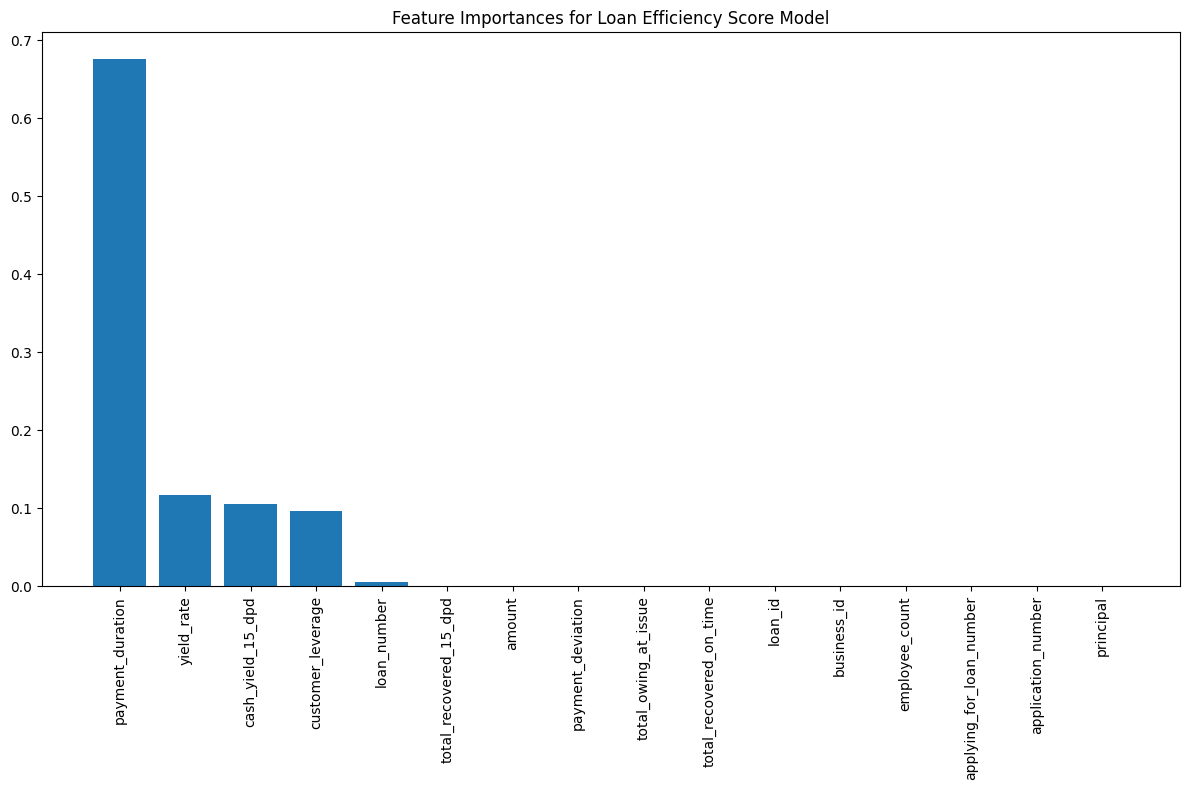

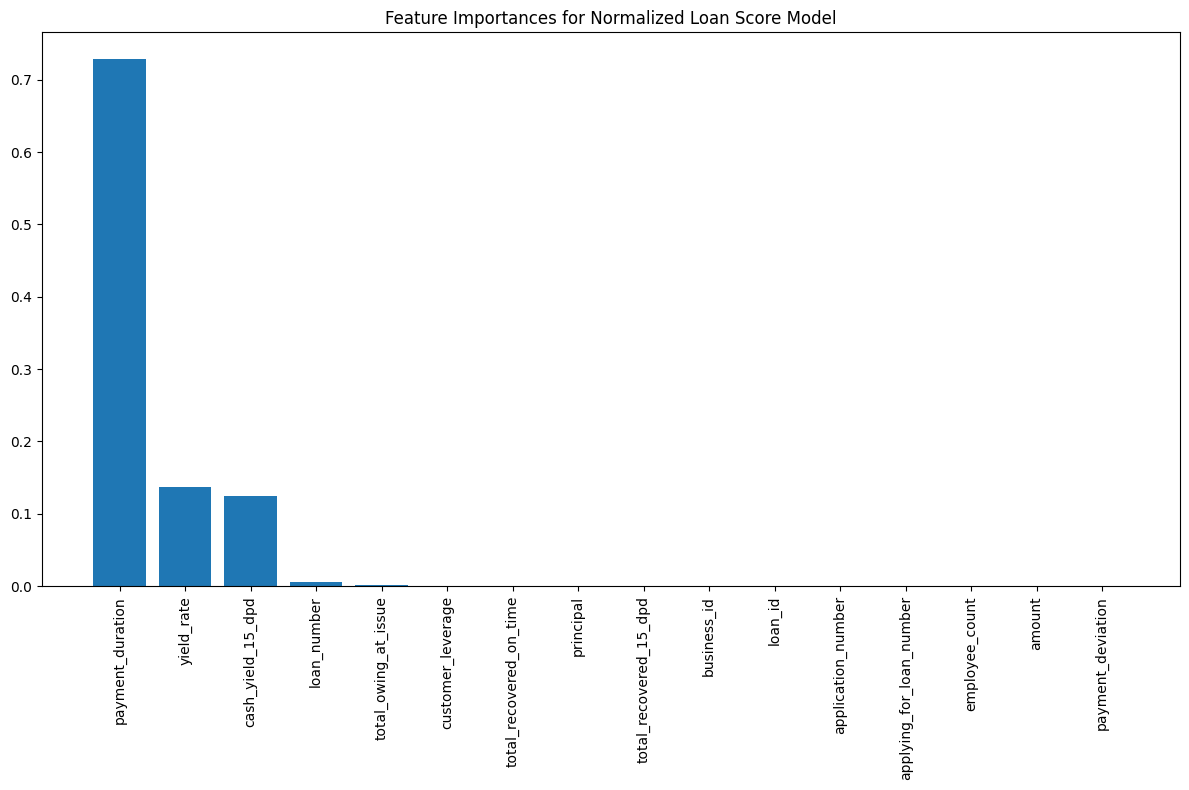

In [17]:
# Extract feature importances for both models
efficiency_importances = gbm_eff.feature_importances_
norm_importances = gbm_norm.feature_importances_

# Get the feature names
feature_names = features.columns

# Combine feature names with their importances for both models into a matrix
efficiency_importance_matrix = np.column_stack((feature_names, efficiency_importances))
norm_importance_matrix = np.column_stack((feature_names, norm_importances))

# Convert to DataFrame for easier manipulation
efficiency_importance_df = pd.DataFrame(efficiency_importance_matrix, columns=['Feature', 'Importance_Efficiency'])
norm_importance_df = pd.DataFrame(norm_importance_matrix, columns=['Feature', 'Importance_Normalized'])

# Convert Importance columns to numeric for sorting
efficiency_importance_df['Importance_Efficiency'] = pd.to_numeric(efficiency_importance_df['Importance_Efficiency'])
norm_importance_df['Importance_Normalized'] = pd.to_numeric(norm_importance_df['Importance_Normalized'])

# Sort by importance
efficiency_importance_df = efficiency_importance_df.sort_values(by='Importance_Efficiency', ascending=False).reset_index(drop=True)
norm_importance_df = norm_importance_df.sort_values(by='Importance_Normalized', ascending=False).reset_index(drop=True)

# Print the feature importance matrix for copying
print("Loan Efficiency Score Model - Feature Importances:")
print(efficiency_importance_df.to_numpy())

print("\nNormalized Loan Score Model - Feature Importances:")
print(norm_importance_df.to_numpy())

# Visualization of Feature Importances for Loan Efficiency Score Model
plt.figure(figsize=(12, 8))
plt.title("Feature Importances for Loan Efficiency Score Model")
plt.bar(range(len(efficiency_importances)), efficiency_importances[np.argsort(efficiency_importances)[::-1]], align="center")
plt.xticks(range(len(efficiency_importances)), efficiency_importance_df['Feature'], rotation=90)
plt.tight_layout()
plt.show()

# Visualization of Feature Importances for Normalized Loan Score Model
plt.figure(figsize=(12, 8))
plt.title("Feature Importances for Normalized Loan Score Model")
plt.bar(range(len(norm_importances)), norm_importances[np.argsort(norm_importances)[::-1]], align="center")
plt.xticks(range(len(norm_importances)), norm_importance_df['Feature'], rotation=90)
plt.tight_layout()
plt.show()


In [18]:
# Load the test data
test_data = pd.read_csv('machine-learning/test_loan_data.csv')
test_data[string_columns] = test_data[string_columns].fillna('Null').astype(str)
test_data[numerical_columns] = test_data[numerical_columns].fillna(0)


In [19]:
# Format test data for prediction
# Compute the yield rate for the test data
test_data['yield_rate'] = test_data['cash_yield_15_dpd'] / test_data['principal']

# Exclude 'business_id' from the features used for prediction
test_loan_data_encoded = test_data.drop(columns=['business_id'])

test_loan_data_encoded.replace('null', np.nan, inplace=True)
test_loan_data_encoded = pd.get_dummies(test_loan_data_encoded, columns=string_columns, drop_first=True)
test_data_numeric = test_data.select_dtypes(include=[np.number])

# Ensure test data contains all features used in training
# Align columns with the training set (add missing columns with zeros if needed)
missing_cols = set(features.columns) - set(test_loan_data_encoded.columns)
for col in missing_cols:
    test_data[col] = 0

# Reorder columns to match the training set
test_loan_data_encoded = test_data[features.columns]

In [20]:
# Now we can use the trained models to predict the loan efficiency score and normalized loan score
# Predict Loan Efficiency Score
predicted_efficiency_scores = gbm_eff.predict(test_loan_data_encoded)

# Predict Normalized Loan Score
predicted_normalized_scores = gbm_norm.predict(test_loan_data_encoded)

# Display the first few predictions
predictions = pd.DataFrame({
    'loan_id': test_loan_data_encoded['loan_id'],
    'predicted_efficiency_score': predicted_efficiency_scores,
    'predicted_normalized_score': predicted_normalized_scores
})

predictions.head()

,loan_id,predicted_efficiency_score,predicted_normalized_score
0,1003730,-0.532344,1.413710
1,986527,-1.119848,1.820648
2,985254,0.100143,1.210573
3,989887,-7.947999,-9.982370
4,994582,0.100143,1.210573
